# Hallway Experiments in Curriculum Learning

-------------------------------


Salkey, Jayson

28/06/2018

-----------------------------------


## Context

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

## Background reading

* Sutton and Barto (2018), Chapters 6-7 + 9-11

# Setup

### Import Useful Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from collections import namedtuple

### Set options

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=1)

### Helper functions

In [3]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=None, vmax=None):
  vmin = np.min(values)
  vmax = np.max(values)
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(action_values, vmin=None, vmax=None):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    plot_values(q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)
  

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

## Assignment 2 [50pts in total + 10 BONUS pts]

### A grid world

In [4]:
class Grid(object):

  def __init__(self, tabular=True, vision_size=1, discount=0.98, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1, -5, -1, -1, -1, -1, -6, -1, -1, -1, -1, 10, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    ])
      
    
    self._start_state = (3, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy
    self._tabular = tabular
    self._vision_size = vision_size
    self._discount = discount
  
  def resetState(self):
    self._state = self._start_state
    
  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != -1, interpolation="nearest", cmap='pink')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(3, 2, r"$\mathbf{S}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==10)
    plt.text(goal_x, goal_y, r"$\mathbf{G}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==-5)
    plt.text(goal_x, goal_y, r"$\mathbf{D}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==-6)
    plt.text(goal_x, goal_y, r"$\mathbf{D}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  def get_obs(self):
    y, x = self._state
    return self.get_obs_at(x, y)

  def get_obs_at(self, x, y):
    if self._tabular:
      return y*self._layout.shape[1] + x
    else:
      v = self._vision_size
      location = np.clip(-self._layout[y-v:y+v+1,x-v:x+v+1], 0, 1)
      return location

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    discount = self._discount
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -1
      new_state = (y, x)
    elif self._layout[new_y, new_x] != 0: # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    else:
      reward = float((new_y + new_x)) / float(np.sum(self._layout.shape))
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)
    
    self._state = new_state

    return reward, discount, self.get_obs()
    

### A hallway world

In [5]:
class Hallway(object):

  def __init__(self, goal_loc, goal=5, tabular=True, vision_size=1, discount=0.98, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    
    self.goal_loc_r = goal_loc[0]
    self.goal_loc_c = goal_loc[1]
    
#     self._layout = np.array([
#       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
#       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
#       [-1, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
#       [-1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1],
#       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
#       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
#       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
#       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
#       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
#       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
#       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
#       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
#       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
#     ])
    
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    ])
    
    self._layout[self.goal_loc_r,self.goal_loc_c] = goal
    self._goal = goal
    self._start_state = (8, 3)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy
    self._tabular = tabular
    self._vision_size = vision_size
    self._discount = discount
  
  def resetState(self):
    self._state = self._start_state
    
  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != -1, interpolation="nearest", cmap='pink')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(8, 3, r"$\mathbf{S}$", ha='center', va='center')
    goal_y, goal_x = np.where(self._layout==self._goal)
    plt.text(goal_x, goal_y, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  def get_obs(self):
    y, x = self._state
    return self.get_obs_at(x, y)

  def get_obs_at(self, x, y):
    if self._tabular:
      return y*self._layout.shape[1] + x
    else:
      v = self._vision_size
      location = np.clip(-self._layout[y-v:y+v+1,x-v:x+v+1], 0, 1)
      return location

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    discount = self._discount
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -1
      new_state = (y, x)
    elif self._layout[new_y, new_x] != 0: # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    else:
      #reward = float((new_y + new_x)) / float(np.sum(self._layout.shape))
      reward = 0
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)
    
    self._state = new_state

    return reward, discount, self.get_obs()
    

### The grid

The cell below shows the `Grid` environment that we will use. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-1` for bumping into a wall, `+10` for reaching the goal, and `(x + y)/(height + width)` otherwise, which encourages the agent to go right and down.  The episode ends when the agent reaches the goal.  At the end of the left-most two corridors, there are distractor 'goals' (marked `D`) that give a reward of $-5$ and $-6$, and then also terminate the episode.  The discount, on continuing steps, is $\gamma = 0.98$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

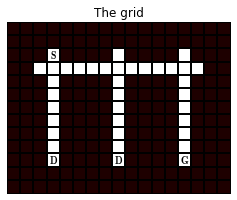

In [6]:
grid = Grid()
grid.plot_grid()

### The Hallway(s)

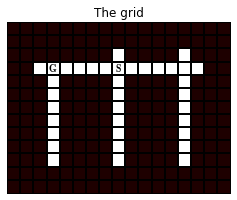

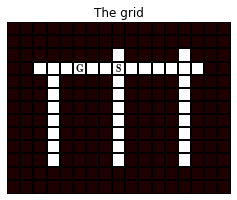

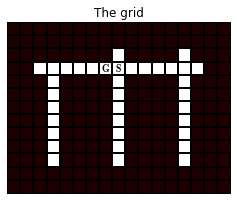

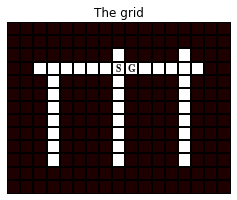

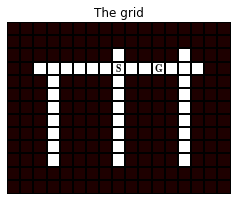

In [7]:
# goal_loc has format (row, col)
tasks = []
for x in xrange(0,5):
  tasks.append(Hallway(goal_loc = (3, (3+x*2))))
  tasks[-1].plot_grid()


## Implement agents
**[10 pts]** In the next code cell, implement an agent that uses **tabular Sarsa** to learn action values.  The agent should act according to an $\epsilon$-greedy policy with respect to its action values.

The agent will be initialized with:
```
agent = Sarsa(number_of_states=grid._layout.size,
              number_of_actions=4,
              grid.get_obs())
```

In [8]:
class Sarsa(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, step_size=0.1):
    self._q = np.zeros((number_of_states, number_of_actions))
#     if double:
#       self._q2 = np.zeros((number_of_states, number_of_actions))
    self._s = initial_state
    self._initial_state = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size

#     self._double = double
    self._last_action = 0
  
  def resetState(self):
    self._s = self._initial_state 
    
  def _target_policy(self, q, a):
    return np.eye(len(q))[a]
 
  def _behaviour_policy(self, q, train):
    return epsilon_greedy(q, 0.1) if train == True else np.random.choice(np.where(np.max(q) == q)[0])

  
  @property
  def q_values(self):
#     if self._double:
#       return (self._q + self._q2)/2
#     else:
    return self._q

  def step(self, r, g, s, train):
#     if self._double:
#       next_action = self._behaviour_policy(self.q_values[s,:])
#       if np.random.random() <= 0.5:
#         expectation = np.sum(self._target_policy(self._q[s,:], next_action) * self._q2[s,:])
#         self._q[self._s,self._last_action] += self._step_size*(r + g*expectation - self._q[self._s,self._last_action])
#         #self._q[self._s,self._last_action] += self._step_size*(r + g*self._q2[s,np.argmax(target_policy(self._q[s,:], next_action))] - self._q[self._s,self._last_action])
#       else:
#         expectation = np.sum(self._target_policy(self._q2[s,:], next_action) * self._q[s,:])
#         self._q2[self._s,self._last_action] += self._step_size*(r + g*expectation - self._q2[self._s,self._last_action])   
#         #self._q2[self._s,self._last_action] += self._step_size*(r + g*self._q[s,np.argmax(target_policy(self._q2[s,:], next_action))] - self._q2[self._s,self._last_action])    
#       self._s = s
#       self._last_action = next_action
#       return self._last_action
#     else:
    next_action = self._behaviour_policy(self._q[s,:], train)
    
    if train == True:
      # This is expected sarsa, but still functions as expected.
      expectation = np.sum(self._target_policy(self._q[s,:], next_action) * self._q[s,:])
      self._q[self._s,self._last_action] += self._step_size*(r + g*expectation - self._q[self._s,self._last_action])
      #self._q[self._s,self._last_action] += self._step_size*(r + g*self._q[s,np.argmax(target_policy(self._q[s,:], next_action))] - self._q[self._s,self._last_action])
    
    self._s = s
    self._last_action = next_action
    return self._last_action

**[20 pts]** Implement an agent that uses **neural Sarsa** to learn action values.  The agent should expect a nxn input which it should flatten into a vector, and then pass through a multi-layer perceptron with a single hidden layer with 100 hidden nodes and ReLU activations.  Each weight layer should also have a bias.  Initialize all weights uniformly randomly in $[-0.05, 0.05]$.

```
NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
            number_of_hidden=100,
            number_of_actions=4,
            initial_state=grid.get_obs(),
            step_size=0.01)
```

The number `vision_size` will be either 1 or 2 below.  The input vector will be of size $(2v + 1)^2$, which will correspond to a square local view of the grid, centered on the agent, and of size $(2v + 1) \times (2v + 1)$ (so either 3x3 or 5x5).

You are allowed, but not mandated, to use TensorFlow to implement this agent.  (The network is small enough that you can also use numpy, but then you have to implement your own backprop.)  Please document the code clearly, especially on non-trivial operations.

In [9]:
class NeuralSarsa(object):

  def __init__(self, number_of_features, number_of_hidden, number_of_actions, initial_state, step_size=0.01):
    tf.reset_default_graph()
    self._prev_action = 0
    self._step = step_size
    self._num_features = number_of_features
    self._num_action = number_of_actions
    self._num_hidden = number_of_hidden
    self._initial_state = initial_state
    self._s = initial_state
    self._s = np.reshape(self._s, (1,-1))
    self._times_trained = 0
    
    self.handleTF()
  
#   def resetState(self):
#     self._s = self._initial_state 
#     self._s = np.reshape(self._s, (1,-1))
    
  def handleTF(self):
    self._sess = tf.Session()
    #tf.reset_default_graph()
    self.rewTensor = tf.placeholder(tf.float64)
    self.disTensor = tf.placeholder(tf.float64)
    self.nqTensor = tf.placeholder(tf.float64)
    self.actionTensor = tf.placeholder(tf.int32)
    self.stateTensor = tf.placeholder(tf.float64, shape=(1,self._num_features))
    self._dense_1 = tf.layers.dense(self.stateTensor,
                                    self._num_hidden, activation=tf.nn.relu,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._dense_2 = tf.layers.dense(self._dense_1,
                                    self._num_action, activation=None,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._q = tf.reshape(self._dense_2, (self._num_action,))    
    self._cost = tf.losses.mean_squared_error(self.rewTensor + self.disTensor*self.nqTensor, self._q[self.actionTensor])
    self._opt = tf.train.GradientDescentOptimizer(self._step).minimize(self._cost)
    
    init = tf.global_variables_initializer()
    self._sess.run(init)

  def _target_policy(self, q, a):
    return np.eye(len(q))[a]
 
  def _behaviour_policy(self, q, train):    
    return epsilon_greedy(q, 0.1) if train == True else np.random.choice(np.where(np.max(q) == q)[0])

  def q(self, obs):
    #print [n.name for n in tf.get_default_graph().as_graph_def().node]
    obs = np.reshape(obs,(1,-1))
    #print obs
    t = self._sess.run(self._q, {self.stateTensor: obs})
    return t
  
  def step(self, r, g, s, train):
    # This function should return an action
    q_nxtState = np.reshape(self.q(s), (-1,))
    next_action = self._behaviour_policy(q_nxtState, train)
    target = self._target_policy(q_nxtState, next_action)
    target = np.random.choice(np.where(np.max(target) == target)[0])
    
    # Optimiser
    if train == True:
      vob = q_nxtState[target]
      self._sess.run(self._opt,{
          self.nqTensor: vob,
          self.rewTensor: r,
          self.disTensor: g,
          self.actionTensor: self._prev_action,
          self.stateTensor: self._s})
      

    
    self._s = np.reshape(s, (1,-1))
    self._prev_action = next_action
    return next_action

In [10]:
class DQN(object):

  def __init__(self, number_of_features, number_of_hidden, number_of_actions, initial_state, step_size=0.01):
    tf.reset_default_graph()
    self._prev_action = 0
    self._step = step_size
    self._num_features = number_of_features
    self._num_action = number_of_actions
    self._num_hidden = number_of_hidden
    self._initial_state = initial_state
    self._s = initial_state
    self._s = np.reshape(self._s, (1,-1))
    self._times_trained = 0
    
    self.handleTF()
  
#   def resetState(self):
#     self._s = self._initial_state 
#     self._s = np.reshape(self._s, (1,-1))
    
  def handleTF(self):
    self._sess = tf.Session()
    #tf.reset_default_graph()
    self.rewTensor = tf.placeholder(tf.float64)
    self.disTensor = tf.placeholder(tf.float64)
    self.nqTensor = tf.placeholder(tf.float64)
    self.actionTensor = tf.placeholder(tf.int32)
    self.stateTensor = tf.placeholder(tf.float64, shape=(1,self._num_features))
    self._dense_1 = tf.layers.dense(self.stateTensor,
                                    self._num_hidden, activation=tf.nn.relu,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._dense_2 = tf.layers.dense(self._dense_1,
                                    self._num_action, activation=None,
                                    kernel_initializer=tf.random_uniform_initializer(-0.05, 0.05),
                                    bias_initializer=tf.random_uniform_initializer(-0.05, 0.05))
    self._q = tf.reshape(self._dense_2, (self._num_action,))    
    self._cost = tf.losses.mean_squared_error(self.rewTensor + self.disTensor*self.nqTensor, self._q[self.actionTensor])
    self._opt = tf.train.GradientDescentOptimizer(self._step).minimize(self._cost)
    
    init = tf.global_variables_initializer()
    self._sess.run(init)

  def _target_policy(self, q, a):
    return np.eye(len(q))[a]
 
  def _behaviour_policy(self, q, train):    
    return epsilon_greedy(q, 0.1) if train == True else np.random.choice(np.where(np.max(q) == q)[0])

  def q(self, obs):
    #print [n.name for n in tf.get_default_graph().as_graph_def().node]
    obs = np.reshape(obs,(1,-1))
    #print obs
    t = self._sess.run(self._q, {self.stateTensor: obs})
    return t
  
  def step(self, r, g, s, train):
    # This function should return an action
    q_nxtState = np.reshape(self.q(s), (-1,))
    next_action = self._behaviour_policy(q_nxtState, train)
    #target = self._target_policy(q_nxtState, next_action)
    #target = np.random.choice(np.where(np.max(target) == target)[0])
    
    # Optimiser
    if train == True:
      vob = np.max(q_nxtState)
      self._sess.run(self._opt,{
          self.nqTensor: vob,
          self.rewTensor: r,
          self.disTensor: g,
          self.actionTensor: self._prev_action,
          self.stateTensor: self._s})
      

    
    self._s = np.reshape(s, (1,-1))
    self._prev_action = next_action
    return next_action

# Analyse Results

### Run the cells below to train the tabular and neural SARSA agents and to generate plots.

This trains the agents the Grid problem with an epsilon of 0.1.

The plots below will show action values for each of the actions, as well as a state value defined by $v(s) = \sum_a \pi(a|s) q(s, a)$.

## Agent 0: Random

In [11]:
class Random(object):
  """A random agent.
  
  This agent returns an action between 0 and 'number_of_arms', 
  uniformly at random. The 'previous_action' argument of 'step'
  is ignored.
  """

  def __init__(self, number_of_arms):
    self._number_of_arms = number_of_arms
    self.name = 'random'
    self.reset()

  def step(self, previous_action, reward):
    return np.random.randint(self._number_of_arms)
  
  def getProbs(self):
    return np.ones((self._number_of_arms))/self._number_of_arms
  
  def reset(self):
    pass


## Agent 1: REINFORCE agents
Implementation of REINFORCE policy-gradient methods

The policy should be a softmax on action preferences:
$$\pi(a) = \frac{\exp(p(a))}{\sum_b \exp(p(b))}\,.$$

The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.


In [12]:
class REINFORCE(object):
 
  def __init__(self, number_of_arms, step_size=0.1, baseline=False):
    self._number_of_arms = number_of_arms
    self._lr = step_size
    self.name = 'reinforce, baseline: {}'.format(baseline)
    self._baseline = baseline
    self.action_values = np.zeros((2,self._number_of_arms))
    self.action_preferences = np.zeros((1,self._number_of_arms))
    self.total_reward = 0;
    self.number_rewards = 0.
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action != None:
      self.number_rewards += 1.
      self.total_reward += reward
      self.action_values[0,previous_action] += reward
      self.action_values[1,previous_action] += 1.
      self.updatePreferences(previous_action, reward)
#    unvisited = np.where(self.action_values[1,:] == 0.)
#     if unvisited[0].size > 0:
#       return unvisited[0][0]
#     else:
#       return np.random.choice(np.arange(0,self._number_of_arms),p=self.softmax())
    return np.random.choice(np.arange(0,self._number_of_arms),p=self.softmax())
    
  def reset(self):
    self.action_values = np.zeros((2,self._number_of_arms))
    self.action_preferences = np.zeros((1,self._number_of_arms))
    self.number_rewards = 0.
    self.total_reward = 0.
  
  def updatePreferences(self, previous_action, reward):
    if not self._baseline: 
      self.action_preferences[0,previous_action]+=self._lr*reward*(1-self.softmax()[previous_action])
      for i in xrange(0,self._number_of_arms):
        if i != previous_action:
          self.action_preferences[0,i]-=self._lr*reward*self.softmax()[i]
    else:
      self.action_preferences[0,previous_action]+=self._lr*(reward - self.total_reward/self.number_rewards)*(1-self.softmax()[previous_action])
      for i in xrange(0,self._number_of_arms):
        if i != previous_action:
          self.action_preferences[0,i]-=self._lr*(reward - self.total_reward/self.number_rewards)*self.softmax()[i]
    
  def softmax(self):
    q = np.sum(np.exp(self.action_preferences),axis=1)
    t = np.exp(self.action_preferences)/q
    return t.flatten()
  
  def getProbs(self):
    return self.softmax()
  
  
      

## Agent 2: EXP3

In [13]:
class EXP3(object):

  def __init__(self, number_of_arms, gamma):
    self._number_of_arms = number_of_arms
    self.name = 'exp3 Gamma: ' + str(gamma)
    
    self.action_values = np.zeros((2,self._number_of_arms))
    
    self.gamma = gamma
    self.weights = np.ones((1,self._number_of_arms))
    
    self.time = 0.
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action != None:
      xhat = np.zeros((1, self._number_of_arms))
      xhat[0,previous_action] = reward/self.action_values[0,previous_action]
      self.weights = self.weights*np.exp(self.gamma*xhat/self._number_of_arms)
      self.action_values[1,previous_action] += 1.
    self.action_values[0,:] = (1-self.gamma)*(self.weights)/(np.sum(self.weights)) + self.gamma/self._number_of_arms
    action = np.random.choice(self._number_of_arms, p=self.action_values[0,:])
    self.time += 1.
    unvisited = np.where(self.action_values[1,:] == 0.)
    return unvisited[0][0] if unvisited[0].size > 0 else action
  
  def getProbs(self):
    return self.action_values[0,:]
  
  def reset(self):
    self.action_values = np.zeros((2, self._number_of_arms))
    self.weights = np.ones((1, self._number_of_arms))
    self.time = 0
    return

## Agent 3: EXP3.S

In [14]:
class EXP3S(object):

  def __init__(self, number_of_arms, gamma, alpha):
    self._number_of_arms = number_of_arms
    self.name = 'exp3s Gamma: ' + str(gamma) + ', Alpha: ' + str(alpha) 
    
    self.action_values = np.zeros((2,number_of_arms))
    
    self.gamma = gamma
    self.alpha = alpha
    self.weights = np.ones((1,number_of_arms))
    
    self.time = 0.
    self.reset()
  
  def step(self, previous_action, reward):
    if previous_action != None:
      xhat = np.zeros((1, self._number_of_arms))
      xhat[0,previous_action] = reward/self.action_values[0,previous_action]
      # Should the added term be using updated weights as we move across arms, or simultaenous updates?
      #print 'test'
      self.weights = self.weights*np.exp(self.gamma*xhat/self._number_of_arms) + ((np.e*self.alpha)/(self._number_of_arms))*np.sum(self.weights)
      self.action_values[1,previous_action] += 1.
    self.action_values[0,:] = (1-self.gamma)*(self.weights)/(np.sum(self.weights)) + self.gamma/self._number_of_arms
    action = np.random.choice(self._number_of_arms, p=self.action_values[0,:])
    self.time += 1.
    unvisited = np.where(self.action_values[1,:] == 0.)
    return unvisited[0][0] if unvisited[0].size > 0 else action
  
  def getProbs(self):
    return self.action_values[0,:]
  
  def reset(self):
    self.action_values = np.zeros((2, self._number_of_arms))
    self.weights = np.ones((1, self._number_of_arms))
    self.time = 0
    return

## Task Bandit

In [15]:
class TaskBandit(object):
  """An adversarial multi-armed Task bandit."""
  
  
  def __init__(self, rl_agent, tasks, number_of_steps, reward_signal):
    self._unscaled_reward_history = []
    self._number_of_steps = number_of_steps
    self._rl_agent = rl_agent
    self._tasks = tasks
    self._reward_signal = reward_signal
  
  def resetEnvRLAgent(self):
    #########
      # Is this really needed?
    for ide,e in enumerate(self._tasks):
      self._tasks[ide].resetState()
    self._rl_agent.resetState()
    #########
    
  def step(self, action_task_id):
    
    start_time = time.time()
    
    if self._reward_signal == 'PG':
      # Prediction Gain
      reward_before, _ = run_step(self._tasks[action_task_id], self._rl_agent, self._number_of_steps, False)
      run_step(self._tasks[action_task_id], self._rl_agent, self._number_of_steps, True)
      reward_after, _ = run_step(self._tasks[action_task_id], self._rl_agent, self._number_of_steps, False)
      
      v = reward_after - reward_before
    elif self._reward_signal == 'GPG':
      # Gradient Prediction Gain
      pass
    elif self._reward_signal == 'SPG':
      # Self Prediction Gain
      reward_before, _ = run_step(self._tasks[action_task_id], self._rl_agent, self._number_of_steps, False)
      run_step(self._tasks[action_task_id], self._rl_agent, self._number_of_steps, True)
      reward_after, _ = run_step(self._tasks[action_task_id], self._rl_agent, self._number_of_steps, False)
      
      v = reward_after - reward_before
    elif self._reward_signal == 'TPG':
      # Target Prediction Gain
      # On the Last Task
      reward_before, _ = run_step(self._tasks[-1], self._rl_agent, self._number_of_steps, False)
      run_step(self._tasks[action_task_id], self._rl_agent, self._number_of_steps, True)
      reward_after, _ = run_step(self._tasks[-1], self._rl_agent, self._number_of_steps, False)
      v = reward_after - reward_before
    elif self._reward_signal == 'MPG':
      # Mean Prediction Gain
      # On uniformly selected task
      uniform_sampled_task_id = np.random.choice(len(self._tasks))
      reward_before, _ = run_step(self._tasks[uniform_sampled_task_id], self._rl_agent, self._number_of_steps, False)
      run_step(self._tasks[action_task_id], self._rl_agent, self._number_of_steps, True)
      reward_after, _ = run_step(self._tasks[uniform_sampled_task_id], self._rl_agent, self._number_of_steps, False)
      v = reward_after - reward_before
    elif self._reward_signal == 'VCG':
      pass
    elif self._reward_signal == 'GVCG':
      pass
    elif self._reward_signal == 'L2G':
      pass      
    
    duration = time.time() - start_time
    
    
    #rhat = v/(duration)
    
    rhat = v
    
    self._unscaled_reward_history.append(rhat)
    temp_history = np.array(sorted(self._unscaled_reward_history))
    p_20 = np.percentile(temp_history, 20)
    p_80 = np.percentile(temp_history, 80)        
    #self._unscaled_reward_history.append(rhat)


    if action_task_id < 0 or action_task_id >= len(self._tasks):
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action_task_id, len(split_train_tasks)))
    
    r = None
    if rhat <= p_20:
      r = -1.
    elif rhat > p_80:
      r = 1.
    else:
      r = 2.0 * (rhat - p_20)/(p_80 - p_20) - 1.
    return r

In [16]:
def run_experiment(bandit, algs, tasks, number_of_steps_of_selecting_tasks, number_of_steps, repetitions, vision_size, tabular, agent_type, hidden_units, step_size, reward_signal):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  action_dict = {}
  prob_dict = {}
  entropy_dict = {}
  
  for alg in algs:
    print 'Running:', alg
    #bandit = TaskBandit(64, 32, reward_signal, 0.01)
    #bandit = TaskBandit(rl_agent, tasks)
    reward_dict[alg.name] = []
    action_dict[alg.name] = []
    prob_dict[alg.name] = []
    entropy_dict[alg.name] = []
    
    accuracies = None
    
    for qq in range(repetitions):
      alg.reset()
      
      if agent_type == 'NEURALSARSA':
        rl_agent = NeuralSarsa(number_of_features=(2*vision_size + 1)**2,
                    number_of_hidden=hidden_units,
                    number_of_actions=4,
                    initial_state=tasks[0].get_obs(),
                    step_size=step_size)
      elif agent_type == 'DQN':
        rl_agent = DQN(number_of_features=(2*vision_size + 1)**2,
                    number_of_hidden=hidden_units,
                    number_of_actions=4,
                    initial_state=tasks[0].get_obs(),
                    step_size=step_size)
      else:
        rl_agent = Sarsa(number_of_states=tasks[0]._layout.size,
                number_of_actions=4,
                initial_state=tasks[0].get_obs())
      
      bandit = TaskBandit(rl_agent, tasks, number_of_steps, reward_signal)
      
      reward_dict[alg.name].append([])
      action_dict[alg.name].append([])
      prob_dict[alg.name].append([])
      entropy_dict[alg.name].append([])
      action = None
      reward = None
      prob = None
      entropy = None
      
      for i in range(number_of_steps_of_selecting_tasks):
        #print i
#         if i % 100 == 0:
#           print 'Rep: {}, Step: {}'.format(qq, i)
        try:
          action = alg.step(action, reward)
          prob = alg.getProbs()
          
          entropy = -1.0 * np.sum(prob * np.log(prob))
          
        except:
            raise ValueError(
              "The step function of algorithm `{}` failed.\
              Perhaps you have a bug, such as a typo.\
              Or, perhaps your value estimates or policy has diverged.\
              (E.g., internal quantities may have become NaNs.)\
              Try adding print statements to see if you can find a bug.".format(alg.name))
        reward = bandit.step(action)
        reward_dict[alg.name][-1].append(reward)
        action_dict[alg.name][-1].append(action)
        prob_dict[alg.name][-1].append(prob.copy())
        entropy_dict[alg.name][-1].append(entropy)
      
#       if not (accuracies is None):
#         accuracies += np.array(bandit.getSPGAccuracyList())
#       else:
#         accuracies = np.array(bandit.getSPGAccuracyList())
      
    
#     accuracies /= repetitions
      
#     plt.figure()
#     plt.plot(accuracies)
#     plt.title('Task Bandit, ' + alg.name + ', Reward Signal: ' + reward_signal)
#     plt.xlabel('Time')
#     plt.ylabel('Accuracy')
  
  return reward_dict, action_dict, prob_dict, entropy_dict

def train_task_agents(agents, number_of_arms, number_of_steps_of_selecting_tasks, number_of_steps, tasks, reward_signal, repetitions=1, vision_size=1, tabular=False, agent_type='norm', hidden_units=100, step_size=0.01):
  bandit = None
  reward_dict, action_dict, prob_dict, entropy_dict = run_experiment(bandit, agents, tasks, number_of_steps_of_selecting_tasks, number_of_steps, repetitions, vision_size, tabular, agent_type, hidden_units, step_size, reward_signal)
  
  smoothed_rewards = {}
  smoothed_actions = {}
  smoothed_probs = {}
  smoothed_entropies = {}
  
  agent_set = set()
  
  for agent, rewards in reward_dict.items():
    agent_set.add(agent)
    smoothed_rewards[agent] = (np.sum(np.array([np.array(x) for x in rewards]), axis=0)).T
      
  for agent, probs in prob_dict.items():
    smoothed_probs[agent] = (np.sum(np.array([np.array(x) for x in probs]), axis=0)).T

  for agent, entropies in entropy_dict.items():
    smoothed_entropies[agent] = (np.sum(np.array([np.array(x) for x in entropies]), axis=0)).T
  
  for agent in agent_set:
    smoothed_probs[agent] /= repetitions
    smoothed_rewards[agent] /= repetitions    
    
    plt.figure(figsize=(22,20))
    plt.imshow(smoothed_probs[agent])
    plt.title(agent + ', Reward Signal: {}; {}'.format(reward_signal, agent_type))
    plt.xlabel('Time')
    plt.ylabel('Task')

  
  plt.figure(figsize=(12,12))
  plt.title('Maximum Likelihood, \t Reward Signal: {}; {}'.format(reward_signal, agent_type))
  plt.ylabel('Policy Entropy')
  plt.xlabel('Time')
  for agent in agent_set:
    smoothed_entropies[agent] /= repetitions  
    plt.plot(smoothed_entropies[agent], label=agent)
  plt.legend(loc='upper right')

In [17]:
def run_step(env, agent, number_of_steps, train):    
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    
    steps_completed = 0
    total_reward = 0.
    
    while steps_completed != number_of_steps:
      reward, discount, next_state = env.step(action)
      total_reward += reward
      action = agent.step(reward, discount, next_state, train)
      steps_completed += 1
    
    mean_reward = total_reward/number_of_steps

    return total_reward, mean_reward
  
def run_episode(env, agent, number_of_episodes, train):
    # Mean Reward across all the episodes( aka all steps )
    mean_reward = 0.
    
    # Mean Duration per episode
    mean_duration = 0.
    
    # List of (Total Reward Per Epsiode)/(Duration)
    signal_per_episode = np.zeros((1, number_of_episodes))
    reward_per_episode = np.zeros((1, number_of_episodes))
    duration_per_episode = np.zeros((1, number_of_episodes))
    
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    
    episodes_completed = 0
    total_reward_per_episode = 0.
    
    start_time = time.time()
    
    i = 0.
    while episodes_completed != number_of_episodes:
      reward, discount, next_state = env.step(action)
      total_reward_per_episode += reward
      
      if discount == 0:
        duration = time.time() - start_time
        signal_per_episode[0,episodes_completed] = (total_reward_per_episode/duration)
        reward_per_episode[0,episodes_completed] = (total_reward_per_episode)
        duration_per_episode[0,episodes_completed] = (duration)
        
        episodes_completed += 1
        mean_duration += (duration - mean_duration)/(episodes_completed)
        
        start_time = time.time()
        total_reward_per_episode = 0.
        
      action = agent.step(reward, discount, next_state, train)
      mean_reward += (reward - mean_reward)/(i + 1.)
      i += 1.
    
    mean_signal = np.mean(signal_per_episode)
    total_reward = np.sum(reward_per_episode)
    total_duration = np.sum(duration_per_episode)

    return total_reward, total_duration

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=None, vmax=None):
  vmin = np.min(values)
  vmax = np.max(values)
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_action_values(action_values, vmin=None, vmax=None):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    plot_values(q[..., a], vmin=vmin, vmax=vmax)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")


def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)
  

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  # plt.ylim((0, 1.5))
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

In [18]:
number_of_steps_of_selecting_tasks = 200
number_of_steps = 3
reps = 5
reward_signal='MPG'


Running: <__main__.Random object at 0x7f20f453e650>
Running: <__main__.EXP3 object at 0x7f20f453e6d0>
Running: <__main__.EXP3 object at 0x7f20f453e750>
Running: <__main__.REINFORCE object at 0x7f20f453e710>
Running: <__main__.REINFORCE object at 0x7f20f453e350>


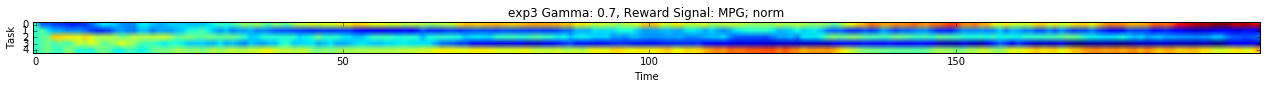

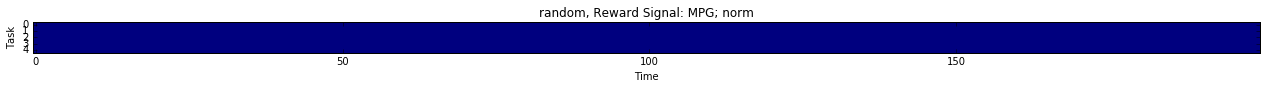

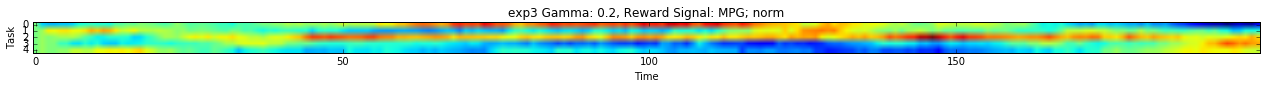

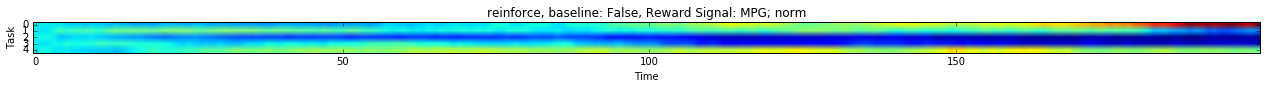

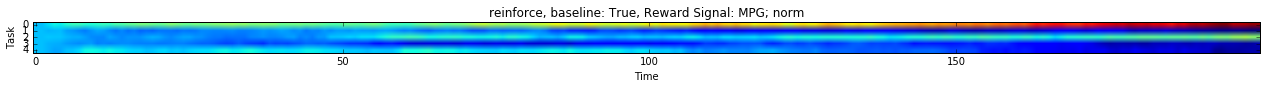

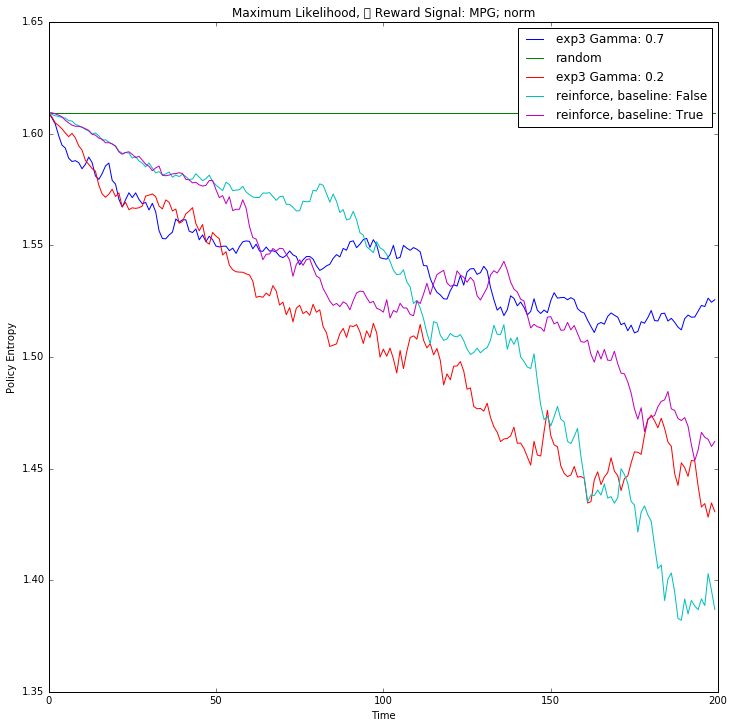

In [19]:
# goal_loc has format (row, col)
tasks = []
for x in xrange(0,5):
  tasks.append(Hallway(goal_loc = (3, (3+2*x)), goal = ((3+2*x)+1), discount=0.98))

# Intrinsically Motivated Curriculum Learning
number_of_arms_tasks = len(tasks)

agents = [
      Random(number_of_arms_tasks),
#     Greedy(number_of_arms),
#     EpsilonGreedy(number_of_arms, 0.1),
#     EpsilonGreedy(number_of_arms, 0.01),
#     UCB(number_of_arms),
      EXP3(number_of_arms_tasks, 0.2),
      EXP3(number_of_arms_tasks, 0.7),
#     EXP3S(number_of_arms_tasks, 0.2, 0.01),
#     EXP3S(number_of_arms_tasks, 0.2, 0.1),
#     EXP3S(number_of_arms_tasks, 0.2, 0.2),
#     EXP3S(number_of_arms_tasks, 0.7, 0.01),
#     EXP3S(number_of_arms_tasks, 0.7, 0.1),
#     EXP3S(number_of_arms_tasks, 0.7, 0.2),
      REINFORCE(number_of_arms_tasks),
      REINFORCE(number_of_arms_tasks, baseline=True),
]

train_task_agents(agents, number_of_arms_tasks, number_of_steps_of_selecting_tasks, number_of_steps, tasks, reward_signal, reps)

  


# # A. Training on the Longest Hallway Only

# # B. Manual Curriculum, shortest to longest hallway

# # C. Uniform Sampling

# # D. Graves Bandit

# # E. RL for Curriculum Selection



# run_experiment(grid, agent, int(1e5))
# q = agent.q_values.reshape(grid._layout.shape + (4,))
# plot_action_values(q)

Running: <__main__.Random object at 0x7f20f44c3ed0>
Running: <__main__.EXP3 object at 0x7f20f44c3f10>
Running: <__main__.EXP3 object at 0x7f20f44c3f50>
Running: <__main__.REINFORCE object at 0x7f20f45677d0>
Running: <__main__.REINFORCE object at 0x7f20f40aaa50>


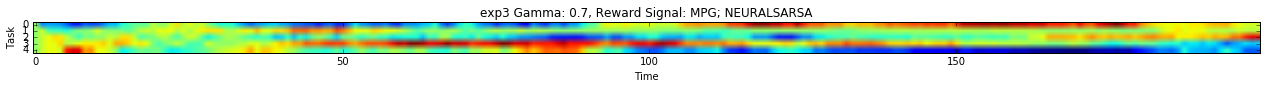

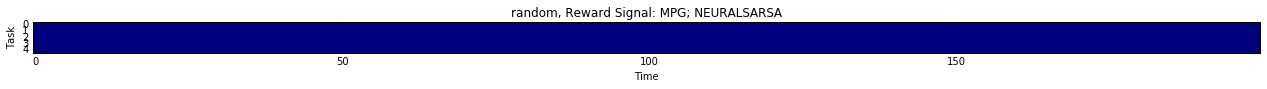

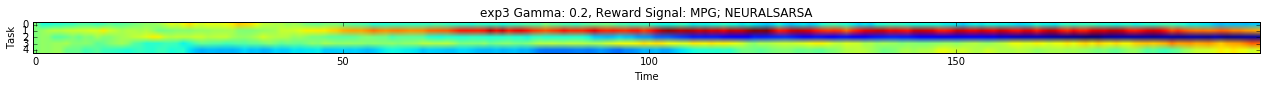

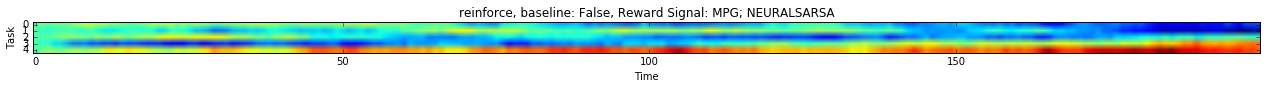

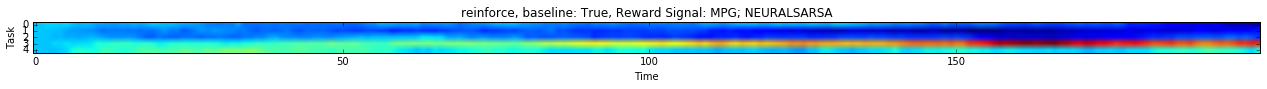

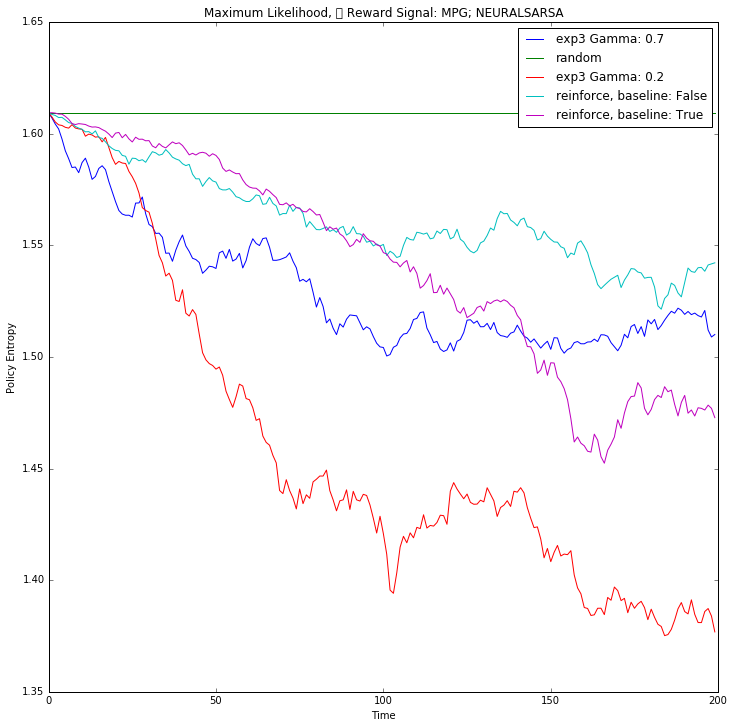

In [20]:
vision_size = 1
tabular_grid = False
agent_type = 'NEURALSARSA'
hidden_units = 100
step_size = 0.01

# goal_loc has format (row, col)
tasks = []
for x in xrange(0,5):
  tasks.append(Hallway(goal_loc = (3, (3+2*x)), goal = (3+2*x)+1, tabular=tabular_grid, vision_size=vision_size, discount=0.98))

# Intrinsically Motivated Curriculum Learning
number_of_arms_tasks = len(tasks)

agents = [
      Random(number_of_arms_tasks),
#     Greedy(number_of_arms),
#     EpsilonGreedy(number_of_arms, 0.1),
#     EpsilonGreedy(number_of_arms, 0.01),
#     UCB(number_of_arms),
      EXP3(number_of_arms_tasks, 0.2),
      EXP3(number_of_arms_tasks, 0.7),
#     EXP3S(number_of_arms_tasks, 0.2, 0.01),
#     EXP3S(number_of_arms_tasks, 0.2, 0.1),
#     EXP3S(number_of_arms_tasks, 0.2, 0.2),
#     EXP3S(number_of_arms_tasks, 0.7, 0.01),
#     EXP3S(number_of_arms_tasks, 0.7, 0.1),
#     EXP3S(number_of_arms_tasks, 0.7, 0.2),
      REINFORCE(number_of_arms_tasks),
      REINFORCE(number_of_arms_tasks, baseline=True),
]

train_task_agents(agents,
                  number_of_arms_tasks,
                  number_of_steps_of_selecting_tasks,
                  number_of_steps,
                  tasks,
                  reward_signal,
                  reps,
                  vision_size,
                  tabular_grid,
                  agent_type,
                  hidden_units,
                  step_size)

#h, w = grid._layout.shape
#obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
#qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
#plot_action_values(qs)

Running: <__main__.Random object at 0x7f20f40ff410>
Running: <__main__.EXP3 object at 0x7f20f42a9b90>
Running: <__main__.EXP3 object at 0x7f20f42a9c10>
Running: <__main__.REINFORCE object at 0x7f20f42a9c50>
Running: <__main__.REINFORCE object at 0x7f20f42a9b10>


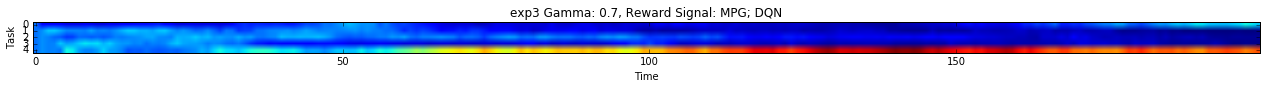

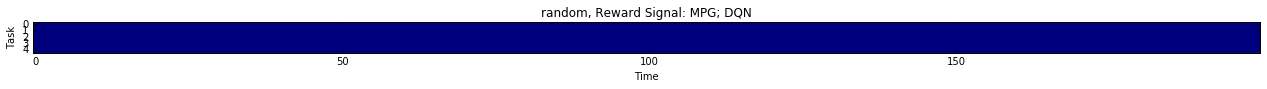

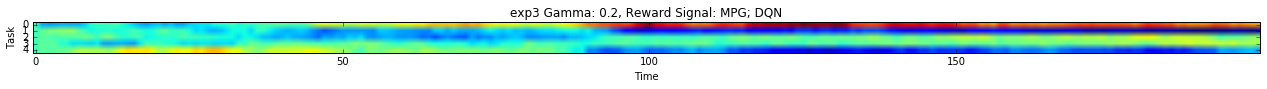

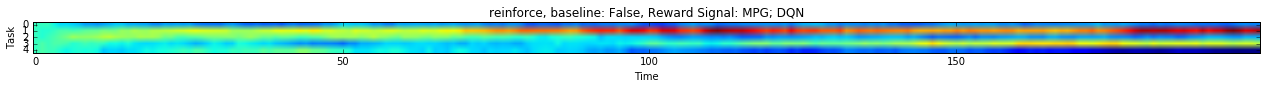

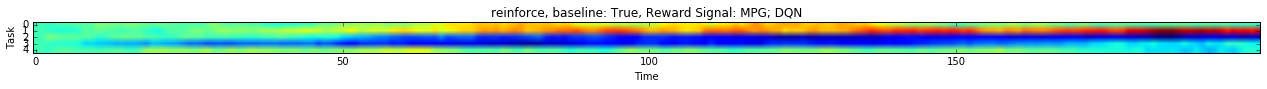

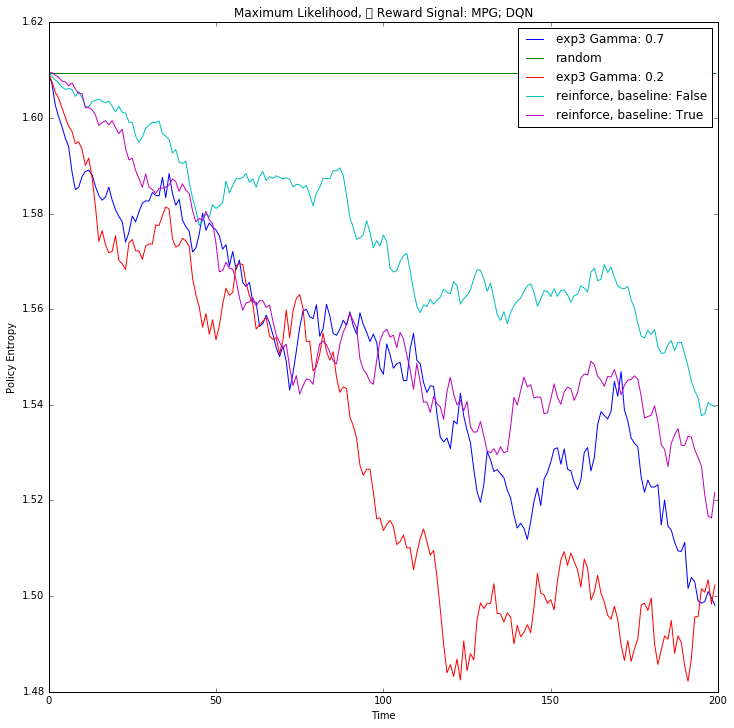

In [21]:
vision_size = 1
tabular_grid = False
agent_type = 'DQN'
hidden_units = 100
step_size = 0.01

# goal_loc has format (row, col)
tasks = []
for x in xrange(0,5):
  tasks.append(Hallway(goal_loc = (3, (3+2*x)), goal = (3+2*x)+1, tabular=tabular_grid, vision_size=vision_size, discount=0.98))

# Intrinsically Motivated Curriculum Learning
number_of_arms_tasks = len(tasks)

agents = [
      Random(number_of_arms_tasks),
#     Greedy(number_of_arms),
#     EpsilonGreedy(number_of_arms, 0.1),
#     EpsilonGreedy(number_of_arms, 0.01),
#     UCB(number_of_arms),
      EXP3(number_of_arms_tasks, 0.2),
      EXP3(number_of_arms_tasks, 0.7),
#     EXP3S(number_of_arms_tasks, 0.2, 0.01),
#     EXP3S(number_of_arms_tasks, 0.2, 0.1),
#     EXP3S(number_of_arms_tasks, 0.2, 0.2),
#     EXP3S(number_of_arms_tasks, 0.7, 0.01),
#     EXP3S(number_of_arms_tasks, 0.7, 0.1),
#     EXP3S(number_of_arms_tasks, 0.7, 0.2),
      REINFORCE(number_of_arms_tasks),
      REINFORCE(number_of_arms_tasks, baseline=True),
]

train_task_agents(agents,
                  number_of_arms_tasks,
                  number_of_steps_of_selecting_tasks,
                  number_of_steps,
                  tasks,
                  reward_signal,
                  reps,
                  vision_size,
                  tabular_grid,
                  agent_type,
                  hidden_units,
                  step_size)

#h, w = grid._layout.shape
#obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
#qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
#plot_action_values(qs)

Running: <__main__.Random object at 0x7f20f484aa90>
Running: <__main__.EXP3 object at 0x7f20f484ac10>
Running: <__main__.EXP3 object at 0x7f20f484abd0>
Running: <__main__.REINFORCE object at 0x7f20f484ab90>
Running: <__main__.REINFORCE object at 0x7f20f48f2990>


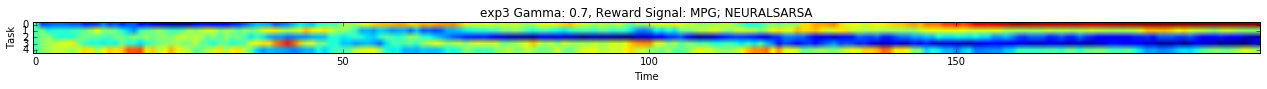

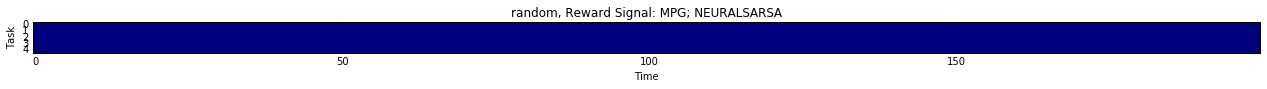

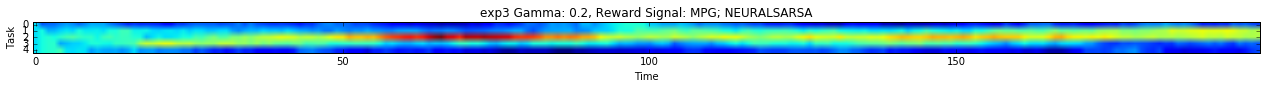

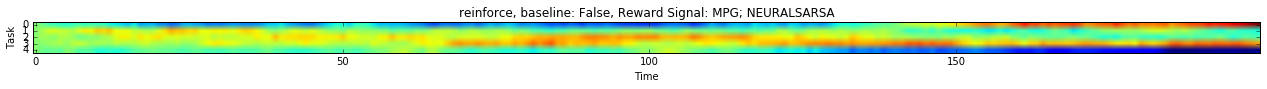

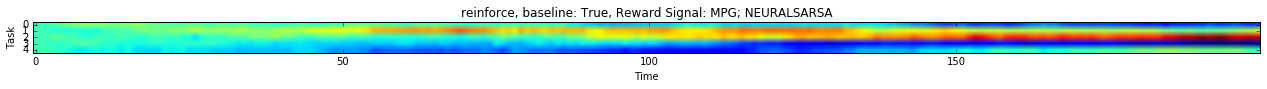

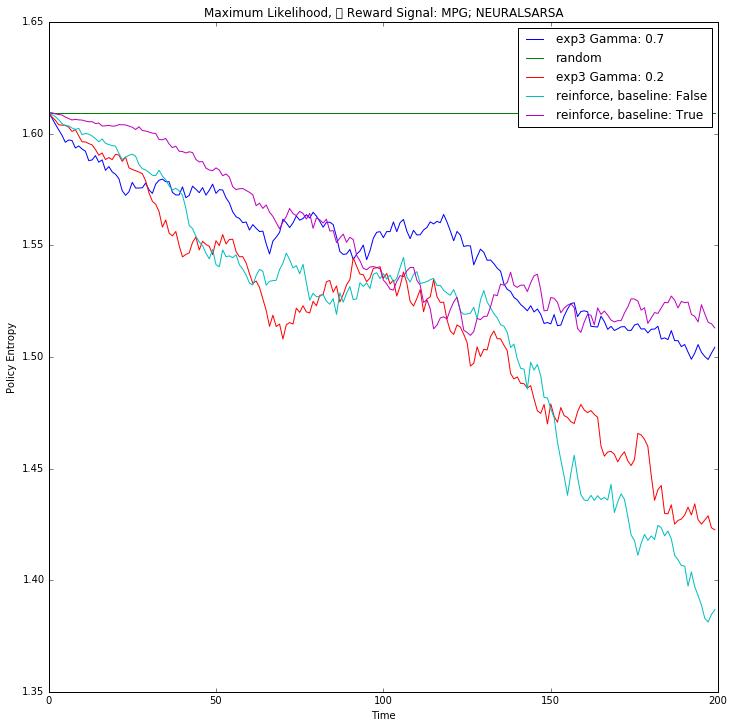

In [22]:
vision_size = 2
tabular_grid = False
agent_type = 'NEURALSARSA'
hidden_units = 100
step_size = 0.01

# goal_loc has format (row, col)
tasks = []
for x in xrange(0,5):
  tasks.append(Hallway(goal_loc = (3, (3+2*x)), goal = (3+2*x)+1, tabular=tabular_grid, vision_size=vision_size, discount=0.98))

# Intrinsically Motivated Curriculum Learning

number_of_arms_tasks = len(tasks)

agents = [
      Random(number_of_arms_tasks),
#     Greedy(number_of_arms),
#     EpsilonGreedy(number_of_arms, 0.1),
#     EpsilonGreedy(number_of_arms, 0.01),
#     UCB(number_of_arms),
      EXP3(number_of_arms_tasks, 0.2),
      EXP3(number_of_arms_tasks, 0.7),
#     EXP3S(number_of_arms_tasks, 0.2, 0.01),
#     EXP3S(number_of_arms_tasks, 0.2, 0.1),
#     EXP3S(number_of_arms_tasks, 0.2, 0.2),
#     EXP3S(number_of_arms_tasks, 0.7, 0.01),
#     EXP3S(number_of_arms_tasks, 0.7, 0.1),
#     EXP3S(number_of_arms_tasks, 0.7, 0.2),
      REINFORCE(number_of_arms_tasks),
      REINFORCE(number_of_arms_tasks, baseline=True),
]

train_task_agents(agents,
                  number_of_arms_tasks,
                  number_of_steps_of_selecting_tasks,
                  number_of_steps,
                  tasks,
                  reward_signal,
                  reps,
                  vision_size,
                  tabular_grid,
                  agent_type,
                  hidden_units,
                  step_size)

#h, w = grid._layout.shape
#obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
#qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
#plot_action_values(qs)

Running: <__main__.Random object at 0x7f20ea67f9d0>
Running: <__main__.EXP3 object at 0x7f20ea67fa10>
Running: <__main__.EXP3 object at 0x7f20f4121f90>
Running: <__main__.REINFORCE object at 0x7f20f4121ed0>
Running: <__main__.REINFORCE object at 0x7f20f4121390>


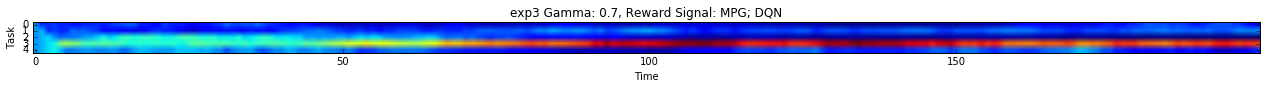

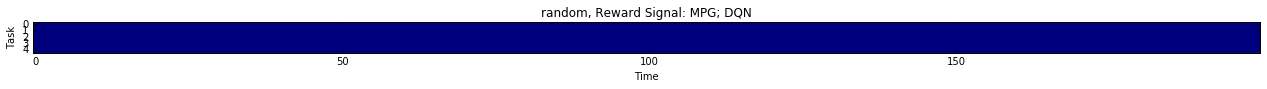

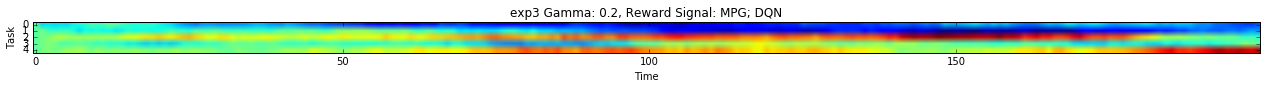

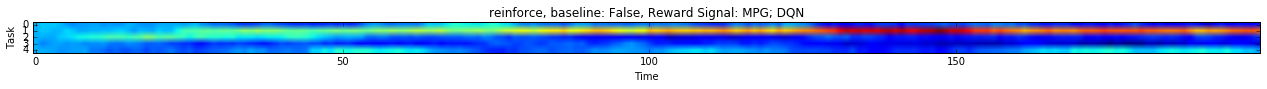

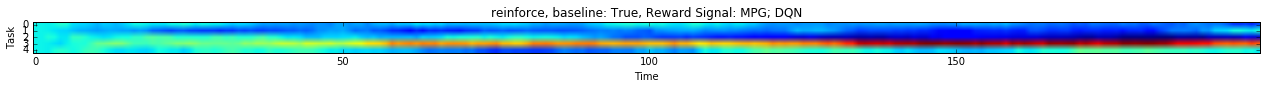

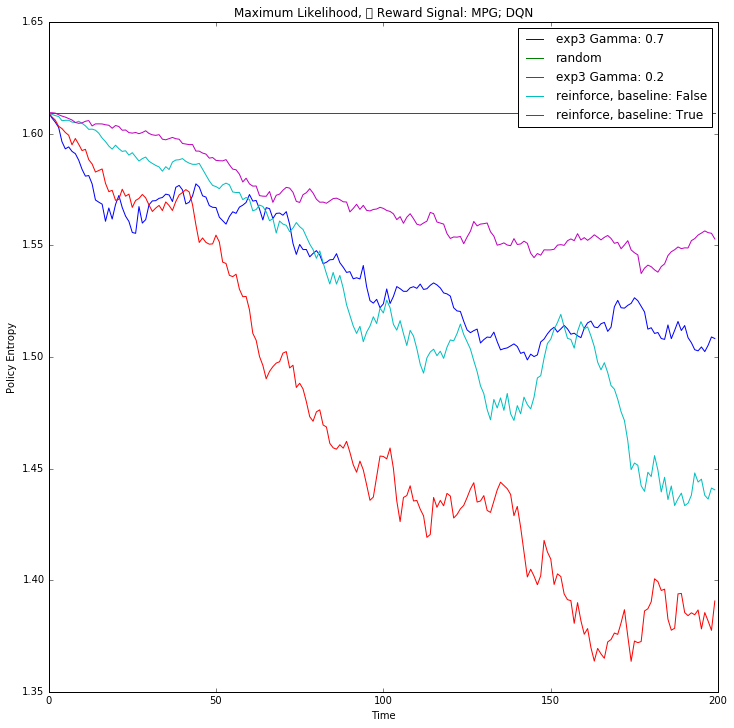

In [23]:
vision_size = 2
tabular_grid = False
agent_type = 'DQN'
hidden_units = 100
step_size = 0.01

# goal_loc has format (row, col)
tasks = []
for x in xrange(0,5):
  tasks.append(Hallway(goal_loc = (3, (3+2*x)), goal = (3+2*x)+1, tabular=tabular_grid, vision_size=vision_size, discount=0.98))

# Intrinsically Motivated Curriculum Learning
number_of_arms_tasks = len(tasks)

agents = [
      Random(number_of_arms_tasks),
#     Greedy(number_of_arms),
#     EpsilonGreedy(number_of_arms, 0.1),
#     EpsilonGreedy(number_of_arms, 0.01),
#     UCB(number_of_arms),
      EXP3(number_of_arms_tasks, 0.2),
      EXP3(number_of_arms_tasks, 0.7),
#     EXP3S(number_of_arms_tasks, 0.2, 0.01),
#     EXP3S(number_of_arms_tasks, 0.2, 0.1),
#     EXP3S(number_of_arms_tasks, 0.2, 0.2),
#     EXP3S(number_of_arms_tasks, 0.7, 0.01),
#     EXP3S(number_of_arms_tasks, 0.7, 0.1),
#     EXP3S(number_of_arms_tasks, 0.7, 0.2),
      REINFORCE(number_of_arms_tasks),
      REINFORCE(number_of_arms_tasks, baseline=True),
]

train_task_agents(agents,
                  number_of_arms_tasks,
                  number_of_steps_of_selecting_tasks,
                  number_of_steps,
                  tasks,
                  reward_signal,
                  reps,
                  vision_size,
                  tabular_grid,
                  agent_type,
                  hidden_units,
                  step_size)

#h, w = grid._layout.shape
#obs = np.array([[grid.get_obs_at(x, y) for x in range(2, w-2)] for y in range(2, h-2)])
#qs = np.array([[[agent.q(o)[a] for a in range(4)] if o[vision_size,vision_size] == 0 else np.zeros((4,)) for o in ob] for ob in obs])
#plot_action_values(qs)